# 폐렴 구별하기
## main quest1

In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model, losses, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = 'data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = 'data/val/*/*'
TEST_PATH = 'data/test/*/*'

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [3]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [4]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [6]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == "PNEUMONIA":
        return 1
    
    return 0  # 폐렴이면 양성(1), 노말이면 음성(0)

In [7]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [8]:
def augment(image,label):
    # 좌우 반전
    image = tf.image.flip_left_right(image)
    return image,label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# add_nomal_ds = train_ds.copy().filter(lambda x, y: not y).map(augment, num_parallel_calls=AUTOTUNE)
# print(add_nomal_ds)
# COUNT_NORMAL += COUNT_NORMAL
# train_ds = train_ds.concatenate(add_nomal_ds)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(len(val_ds))

1047


In [9]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [10]:
BATCH_SIZE = 8

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

624


In [11]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

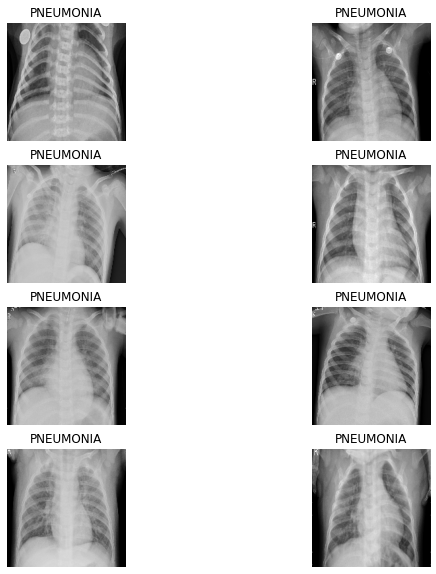

In [12]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4) , n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [13]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [14]:
class ResnetBlock(layers.Layer):
    def __init__(self, num_cnn, n_filters, kernel_size=3, stride=1):
        super(ResnetBlock, self).__init__()
        
        self.blocks = list()
        
        for i in range(num_cnn):
            self.blocks.append(layers.Conv2D(n_filters, kernel_size=kernel_size, strides=stride, padding="same"))
            self.blocks.append(layers.BatchNormalization())
            self.blocks.append(layers.Activation('relu'))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [15]:
class Resnet(Model):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer1 = ResnetBlock(1, 64, 7, 2)
        self.max_pool = layers.MaxPool2D((3, 3), strides=2)
        self.layer2 = ResnetBlock(2, 64, 3)
        self.layer3 = ResnetBlock(2, 128, 3)
        self.layer4 = ResnetBlock(2, 256, 3)
        self.layer5 = ResnetBlock(2, 512, 3)
        self.average_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(2, activation='softmax')
        
    def call(self, x):
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.average_pool(x)
        
        return self.dense(x)

In [16]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

res_model = Resnet()
res_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [17]:
EPOCHS = 10

with tf.device('/GPU:0'):
    model_histoty = res_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        class_weight=class_weight
    )

Epoch 1/10
523/523 [==============================] - 74s 115ms/step - loss: 0.3044 - sparse_categorical_accuracy: 0.8824 - val_loss: 1.3863 - val_sparse_categorical_accuracy: 0.7317
Epoch 2/10
523/523 [==============================] - 60s 114ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9300 - val_loss: 0.3894 - val_sparse_categorical_accuracy: 0.8452
Epoch 3/10
523/523 [==============================] - 59s 114ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.2895 - val_sparse_categorical_accuracy: 0.8865
Epoch 4/10
523/523 [==============================] - 59s 114ms/step - loss: 0.1592 - sparse_categorical_accuracy: 0.9486 - val_loss: 25.4491 - val_sparse_categorical_accuracy: 0.2673
Epoch 5/10
523/523 [==============================] - 60s 114ms/step - loss: 0.1427 - sparse_categorical_accuracy: 0.9541 - val_loss: 4.6071 - val_sparse_categorical_accuracy: 0.3413
Epoch 6/10
523/523 [==============================] - 60s 115ms/step - loss: 0.1277 

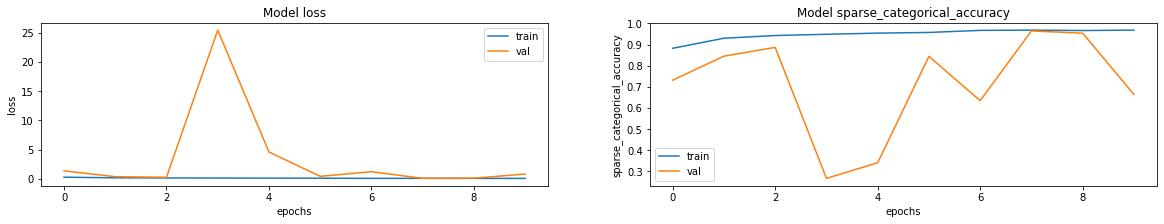

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'sparse_categorical_accuracy']):
    ax[i].plot(model_histoty.history[met])
    ax[i].plot(model_histoty.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [19]:
reslut = res_model.evaluate(test_ds)
print(reslut)

78/78 [==============================] - 5s 61ms/step - loss: 0.6711 - sparse_categorical_accuracy: 0.7163
[0.6711412668228149, 0.7163461446762085]


In [20]:
predictions = res_model.predict(test_ds)

In [21]:
print(predictions)

[[0.9986755  0.00132447]
 [0.5750521  0.4249479 ]
 [0.8324239  0.16757609]
 ...
 [0.07331897 0.92668104]
 [0.00838523 0.9916148 ]
 [0.9792054  0.02079461]]


In [25]:
pre_len = len(predictions)
pre_idx = 0
TP = 0
TN = 0

FP = 0
FN = 0
while pre_idx < pre_len:

    for i, (_, labels) in enumerate(test_ds):
        for label in labels:
            if predictions[pre_idx][0] < predictions[pre_idx][1] == label:
                TP += 1
            elif predictions[pre_idx][0] > predictions[pre_idx][1] == label:
                TN += 1
            
            elif predictions[pre_idx][0] < predictions[pre_idx][1] != label:
                FP += 1
                
            elif predictions[pre_idx][0] > predictions[pre_idx][1] != label:
                FN += 1
            
            pre_idx += 1

In [26]:
TP, TN, FP, FN

(119, 117, 178, 210)

In [28]:
precision = TP / (TP + FP)
precision # 양성이라고 한것에서 실제로도 양성인것

0.4006734006734007

In [29]:
recall = TP / (TP + FN)
recall # 실제 양성인데 양성이라고 한것

0.3617021276595745

In [30]:
acc = (TP + TN) / (TP + FN + FP + TN)
acc

0.3782051282051282